# Task 1: Big Cats
### Alina, Lisa, Ömer and Nikolai

## Import Data

In [1]:
import os

import cv2 as cv
import imgaug.augmenters as iaa
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import pandas as pd
from PIL import Image
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, silhouette_samples, silhouette_score, mutual_info_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.manifold import MDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.cluster import KMeans, Birch, AffinityPropagation
from fcmeans import FCM

plt.rcParams["figure.facecolor"] = "w"

In [2]:
RANDOM_STATE=42

In [3]:
data_path = os.path.join("..", "Data-PR-As2", "BigCats")

In [4]:
class_paths = os.listdir(data_path)
imgs = []
labels = []
for class_ in class_paths:
    path = os.path.join(data_path, class_)
    imgs_of_class = os.listdir(path)
    imgs += [os.path.join(path, x) for x in imgs_of_class]
    labels += [class_] * len(imgs_of_class)

## Data Analysis

In [5]:
print("# observations:", len(labels))

# observations: 200


In [6]:
classes = list(np.unique(labels))
n_classes = len(classes)
print("There are", n_classes, "classes:", classes)

There are 5 classes: ['Cheetah', 'Jaguar', 'Leopard', 'Lion', 'Tiger']


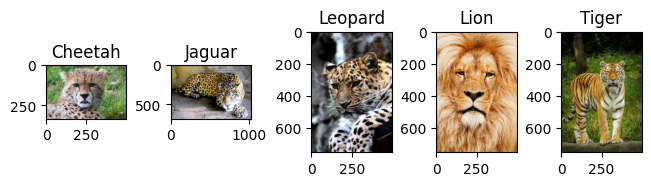

In [7]:
# Visualise one data sample per class
fig, axs = plt.subplots(1, n_classes, constrained_layout=True)
axs = axs.flatten()

for i, class_ in enumerate(classes):
    ob_idx = labels.index(class_)
    with Image.open(imgs[ob_idx]) as img:
        axs[i].imshow(img)
        axs[i].title.set_text(class_)
plt.show()

In [8]:
def plot_class_freq(y):
    ax = y.apply(pd.value_counts).plot(kind='bar', legend=False)
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.show()

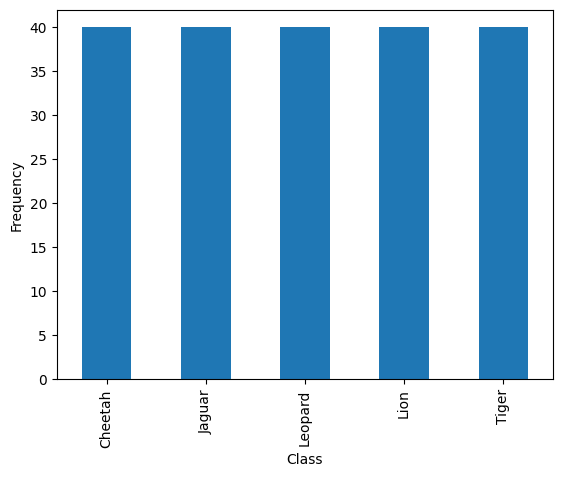

In [9]:
# Check for data imbalance
plot_class_freq(pd.DataFrame(labels))

## Data Augmentation

In [10]:
def aug_data(data, labels, display_idx={}):
    all_imgs = []
    all_labels = []
    aug_seq = iaa.Sequential([
        iaa.Fliplr(0.6, random_state=RANDOM_STATE),
        iaa.PiecewiseAffine(scale=(0.03, 0.05), random_state=RANDOM_STATE),
        iaa.PerspectiveTransform(scale=(0.07, 0.15), random_state=RANDOM_STATE)
    ])

    for i, x in enumerate(data):
        img = cv.imread(x)
        img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
        aug_img = aug_seq(images=[img])

        all_imgs.append(img)
        all_imgs.append(aug_img[0])
        all_labels.append(labels[i])
        all_labels.append(labels[i])

        if i in display_idx:
            fig, axs = plt.subplots(1, 2, constrained_layout=True)
            axs = axs.flatten()
            axs[0].imshow(img)
            axs[0].title.set_text('Original')
            axs[1].imshow(aug_img[0])
            axs[1].title.set_text('Augmented')
            plt.show()

    return all_imgs, all_labels

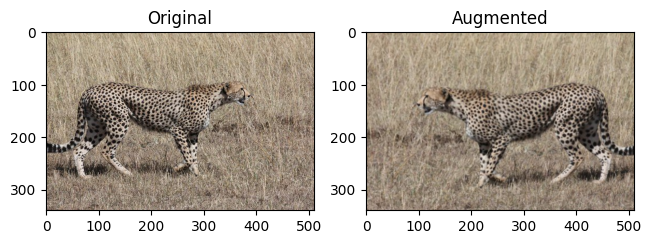

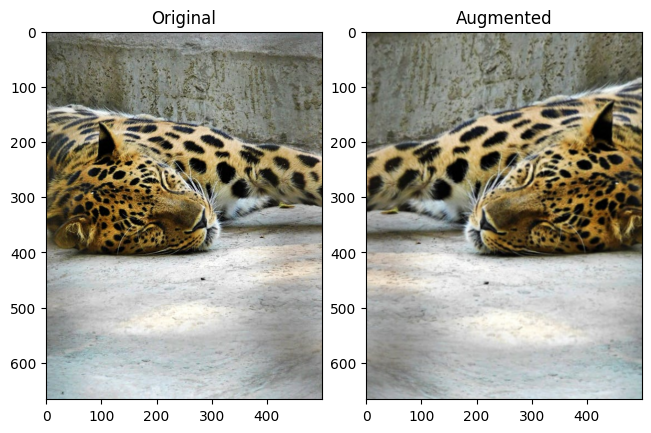

In [11]:
all_imgs, all_labels = aug_data(imgs, labels, {2, 101})

## Classification

In [12]:
img_train, img_test, label_train, label_test = train_test_split(all_imgs, all_labels, test_size=0.2, random_state=RANDOM_STATE)
img_train_flat = [cv.resize(img, (300, 300)).flatten() for img in img_train]
img_test_flat = [cv.resize(img, (300, 300)).flatten() for img in img_test]

### Feature extraction
The features will be extracted using SIFT and ORB.

In [13]:
def extract_features(detector, data, display_idxs={}):
    features = np.array([])
    
    for i, img in enumerate(data):
        bw_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        kp, des = detector.detectAndCompute(bw_img, None)
        features = np.vstack((des, features)) if features.size else des

        if i in display_idxs:
            img_sift = cv.drawKeypoints(bw_img, kp, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            plt.imshow(img_sift)
            plt.show()
    return features

### Bag of Visual Words

Create dictionary by clustering descriptors

In [14]:
def get_kmeans_dict(train_features, cluster_num):
    kmeans = KMeans(n_clusters=cluster_num, random_state=RANDOM_STATE)
    kmeans.fit(train_features)
    return kmeans

Extract BoVW features

In [15]:
# Returns a normalized histogram of the dictionary word frequency
# using the SIFT descriptors of an image
def build_histogram(kmeans_dict, img_des, n_clusters):
    pred = kmeans_dict.predict(img_des)
    hist, _ = np.histogram(pred, bins=n_clusters)
    hist_norm = [float(i)/sum(hist) for i in hist]
    return hist

def get_BOVW_feat(data, labels, kmeans_dict, detector, n_clusters):
    features = []
    for id in range(len(data)):
        if data[id] is not None:
            d = [data[id]]
            features.append(build_histogram(kmeans_dict, extract_features(detector, d), n_clusters))
        else:
            labels.pop(id)
    return features, labels

### Evaluation

In [16]:
def get_f1_score(model, train_data, train_labels, test_data, test_labels):
    model.fit(train_data, train_labels)
    yhat = model.predict(test_data)
    return f1_score(test_labels, yhat, average='micro')

In [17]:
def evaluate_model(model, train_data, train_labels, test_data, test_labels):
    model.fit(train_data, train_labels)
    yhat = model.predict(test_data)

    accuracy = accuracy_score(test_labels, yhat)
    print("Accuracy: {}%".format(accuracy * 100))

    f_1 = f1_score(test_labels, yhat, average='micro')
    print("F_1: {}".format(f_1))

    conf_mat = confusion_matrix(test_labels, yhat)
    conf_mat_df = pd.DataFrame(conf_mat, columns=classes, index=classes)
    sns.set(rc={'figure.facecolor':'white'})
    fig = sns.heatmap(conf_mat_df, annot=True, cmap=sns.cm.rocket_r)
    plt.show()

    all_classes = np.unique(test_labels)
    bin_label_test = label_binarize(test_labels, classes=all_classes)
    try:
        label_score = model.predict_proba(test_data)
    except:
        label_score = model.decision_function(test_data)
        
    # from sklearn documentation on roc curves with changed var names
    false_pos_rate = dict()
    true_pos_rate = dict()
    auc_scores = dict()
    for n_class in range(len(all_classes)):
        false_pos_rate[n_class], true_pos_rate[n_class], _ = roc_curve(bin_label_test[:, n_class], label_score[:, n_class])
        auc_scores[n_class] = auc(false_pos_rate[n_class], true_pos_rate[n_class])
        print("Class: {}, AUC: {}".format(all_classes[n_class], auc_scores[n_class]))
        plt.plot(false_pos_rate[n_class], true_pos_rate[n_class], label=classes[n_class]+" (area = {0:0.2f})".format(auc_scores[n_class]))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="best")
    plt.show()

### Run model

In [18]:
def run_model_grid_search(detector, data_train, label_train, data_test, label_test, n_clusters):
    f1_df = pd.DataFrame(columns=['method','n_estimators','criterion','kernel','n_neighbors','weights','f1-score'])
    all_train_features = extract_features(detector, img_train)

    kmeans_dict = get_kmeans_dict(all_train_features, n_clusters)
    kmeans_train_features, label_train = get_BOVW_feat(data_train, label_train, kmeans_dict, detector, n_clusters)
    kmeans_test_features, label_test = get_BOVW_feat(data_test, label_test, kmeans_dict, detector, n_clusters)

    rfc_criterion = ['gini', 'entropy', 'log_loss']
    rfc_n_estimators = [50, 100, 150, 200]
    for criterion in rfc_criterion:
        for n_estimators in rfc_n_estimators:
            f1 = get_f1_score(RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, random_state=RANDOM_STATE, n_jobs=-1),\
                kmeans_train_features, label_train, kmeans_test_features, label_test)
            new_row = pd.DataFrame({'method':['rfc'], 'n_estimators':[n_estimators], 'criterion':[criterion], 'f1-score':[f1]})
            f1_df = pd.concat([f1_df, new_row], ignore_index=True)
            
    svm_kernel = ['linear', 'poly', 'rbf', 'sigmoid']
    for kernel in svm_kernel:
        f1 = get_f1_score(SVC(kernel=kernel), kmeans_train_features, label_train, kmeans_test_features, label_test)
        new_row = pd.DataFrame({'method':['svm'], 'kernel':[kernel], 'f1-score':[f1]})
        f1_df = pd.concat([f1_df, new_row], ignore_index=True)

    knn_n_neighbors = [3, 5, 7]
    knn_weights = ['uniform', 'distance']
    for n_neighbors in knn_n_neighbors:
        for weights in knn_weights:
            f1 = get_f1_score(KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, n_jobs=-1),\
                kmeans_train_features, label_train, kmeans_test_features, label_test)
            new_row = pd.DataFrame({'method':['knn'], 'n_neighbors':[n_neighbors], 'weights':[weights], 'f1-score':[f1]})
            f1_df = pd.concat([f1_df, new_row], ignore_index=True)

    return f1_df

In [19]:
def run_models(rfc_m, svm_m, knn_m, detector, img_train, label_train, img_test, label_test, n_clusters):
    all_train_features = extract_features(detector, img_train, display_idxs={0, 5})

    kmeans_dict = get_kmeans_dict(all_train_features, n_clusters)
    kmeans_train_features, label_train = get_BOVW_feat(img_train, label_train, kmeans_dict, detector, n_clusters)
    kmeans_test_features, label_test = get_BOVW_feat(img_test, label_test, kmeans_dict, detector, n_clusters)

    print("Evaluation with Random Forest Classifier:")
    evaluate_model(rfc_m, kmeans_train_features, label_train, kmeans_test_features, label_test)

    print("\nEvaluation with SVM:")
    evaluate_model(svm_m, kmeans_train_features, label_train, kmeans_test_features, label_test)

    print("\nEvaluation with KNN Classifier:")
    evaluate_model(knn_m, kmeans_train_features, label_train, kmeans_test_features, label_test)

    return kmeans_train_features, label_train, kmeans_test_features, label_test

### Cross validation

In [20]:
# Returns the best RFC, SVC and KNN model in terms of F1-score after k-fold cross validation
def cross_validation(detector, data, labels, n_clusters, filename, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    f1_df = pd.DataFrame(columns=['method','n_estimators','criterion','kernel','n_neighbors','weights','f1-score'])

    for train_index, test_index in kf.split(data):
        data_train, data_test = [data[index] for index in train_index], [data[index] for index in test_index]
        labels_train, labels_test = [labels[index] for index in train_index], [labels[index] for index in test_index]
        f1_df = pd.concat([f1_df, run_model_grid_search(detector, data_train, labels_train,data_test, labels_test, n_clusters)],\
            ignore_index=True)

    # Get mean and SD of each unique model configuration across all folds       
    f1_mean_df = f1_df.groupby(['method','n_estimators','criterion','kernel','n_neighbors','weights'], dropna=False).mean().reset_index()
    f1_sd_df = f1_df.groupby(['method','n_estimators','criterion','kernel','n_neighbors','weights'], dropna=False).std().reset_index()
    f1_mean_df['sd'] = f1_sd_df['f1-score']
    with open(filename, 'a') as f:
        f.write("\nn_clusters={}\n".format(n_clusters))
        f.write(tabulate(f1_mean_df, headers = 'keys', tablefmt = 'psql'))

    best_rfc = f1_mean_df.where(f1_mean_df.method == 'rfc')['f1-score'].idxmax()
    best_svm = f1_mean_df.where(f1_mean_df.method == 'svm')['f1-score'].idxmax()
    best_knn = f1_mean_df.where(f1_mean_df.method == 'knn')['f1-score'].idxmax()

    return pd.concat([f1_mean_df.loc[[best_rfc]], f1_mean_df.loc[[best_svm]], f1_mean_df.loc[[best_knn]]], ignore_index=True)

### Grid search

In [21]:
def grid_search(detector, img_train, label_train, k, filename):
    tried_cluster_ns = []
    rfc_f1 = []
    svm_f1 = []
    knn_f1 = []

    # The search starts with 50 clusters and will be incremented at each iteration
    n_clusters = 50
    step = 50

    # Counts if performance has been unchanged or lower for each classifier
    lower = [0, 0, 0]
    prev_max_f1 = [0, 0, 0]

    while min(lower) < 2 and n_clusters <= 400:
        print("Mean F1-score (\u00B1 1 SD) for {} clusters after {}-fold cross validation:".format(n_clusters, k))
        f1_df = cross_validation(detector, img_train, label_train, n_clusters, filename, k)
        mean = [f1_df.loc[f1_df['method'] == 'rfc', 'f1-score'].item(), f1_df.loc[f1_df['method'] == 'svm', 'f1-score'].item(),\
             f1_df.loc[f1_df['method'] == 'knn', 'f1-score'].item()]
        print("\t- RFC, n_estimators={}, criterion={}: {} \u00B1 {}".format(f1_df.loc[f1_df['method'] == 'rfc', 'n_estimators'].item(),\
            f1_df.loc[f1_df['method'] == 'rfc', 'criterion'].item(), mean[0], f1_df.loc[f1_df['method'] == 'rfc', 'sd'].item()))
        print("\t- SVM, kernel={}: {} \u00B1 {}".format(f1_df.loc[f1_df['method'] == 'svm', 'kernel'].item(), mean[1],\
             f1_df.loc[f1_df['method'] == 'svm', 'sd'].item()))
        print("\t- KNN, n_neighbors={}, weights={}: {} \u00B1 {}\n".format(f1_df.loc[f1_df['method'] == 'knn', 'n_neighbors'].item(),\
            f1_df.loc[f1_df['method'] == 'knn', 'weights'].item(), mean[2], f1_df.loc[f1_df['method'] == 'knn', 'sd'].item()))
        rfc_f1.append(mean[0])
        svm_f1.append(mean[1])
        knn_f1.append(mean[2])

        tried_cluster_ns.append(n_clusters)
        n_clusters = n_clusters + step
        for i in range(3):
            if mean[i] <= prev_max_f1[i]:
                lower[i] = lower[i] + 1
            else:
                prev_max_f1[i] = mean[i]
                lower[i] = 0

    plt.plot(tried_cluster_ns, rfc_f1, label='Best RFC')
    plt.plot(tried_cluster_ns, svm_f1, label='Best SVM')
    plt.plot(tried_cluster_ns, knn_f1, label='Best KNN')
    plt.xlabel('Number of Clusters')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.show()

### Ensemble

In [22]:
def run_ensembles(rfc_m, svm_m, knn_m, kmeans_train_features, label_train, kmeans_test_features, label_test):
    print("Evaluation with soft voting (RFC, SVM, KNN):")
    e_model = VotingClassifier(estimators=[('rfc', rfc_m), ('svm', svm_m), ('knn', knn_m)], voting='soft')
    evaluate_model(e_model, kmeans_train_features, label_train, kmeans_test_features, label_test)

    print("\nEvaluation with stacking (RFC, SVM, KNN):")
    e_model = StackingClassifier(estimators=[('rfc', rfc_m), ('svm', svm_m), ('knn', knn_m)], final_estimator=svm_m)
    evaluate_model(e_model, kmeans_train_features, label_train, kmeans_test_features, label_test)

## Clustering

In [23]:
def vis_data(data, labels, plot_title):
    mds = MDS(random_state=RANDOM_STATE, n_components=2)
    X_transform = mds.fit_transform(data)

    for class_ in np.unique(labels):
        r_idx = np.where(np.asarray(labels) == class_)
        plt.scatter(X_transform[r_idx, 0], X_transform[r_idx, 1], label=class_)
    plt.title(plot_title)
    plt.xlabel("Coordinate 1")
    plt.ylabel("Coordinate 2")
    plt.legend()
    plt.show()

def clustering_and_vis(model, data, labels, model_name="Birch"):
    vis_data(data, labels, "Original data")
    
    pred = model.fit_predict(data)
    if len(set(pred)) > 1:
        silhouette = silhouette_score(data, pred)
        print("Silhouette: {}\n".format(silhouette))
    else:
        print("Silhouette score cannot be calculated, as only one cluster was found.")
    mutual_info = mutual_info_score(labels, pred)
    print("Mutual information: {}".format(mutual_info))

    vis_data(data, pred, model_name+" Clustering")

## ORB pipeline

### Classification

In [24]:
detector = cv.ORB_create()

#### Grid search

In [25]:
N_FOLDS = 3

Mean F1-score (± 1 SD) for 50 clusters after 3-fold cross validation:
	- RFC, n_estimators=50.0, criterion=entropy: 0.5094339622641509 ± 0.02152957607259707
	- SVM, kernel=poly: 0.5158114383118791 ± 0.06377312847045093
	- KNN, n_neighbors=5.0, weights=distance: 0.4719038382413448 ± 0.012296916061032528

Mean F1-score (± 1 SD) for 100 clusters after 3-fold cross validation:
	- RFC, n_estimators=200.0, criterion=entropy: 0.5094339622641509 ± 0.036564482413114406
	- SVM, kernel=rbf: 0.5437018750367365 ± 0.04859492307974248
	- KNN, n_neighbors=7.0, weights=distance: 0.4500382060777053 ± 0.034381211991854954

Mean F1-score (± 1 SD) for 150 clusters after 3-fold cross validation:
	- RFC, n_estimators=150.0, criterion=gini: 0.4531240815846706 ± 0.014021001877232864
	- SVM, kernel=poly: 0.5155469346969964 ± 0.02213300426838667
	- KNN, n_neighbors=3.0, weights=distance: 0.46558514077470176 ± 0.011993855527930572

Mean F1-score (± 1 SD) for 200 clusters after 3-fold cross validation:
	- RFC, n_e

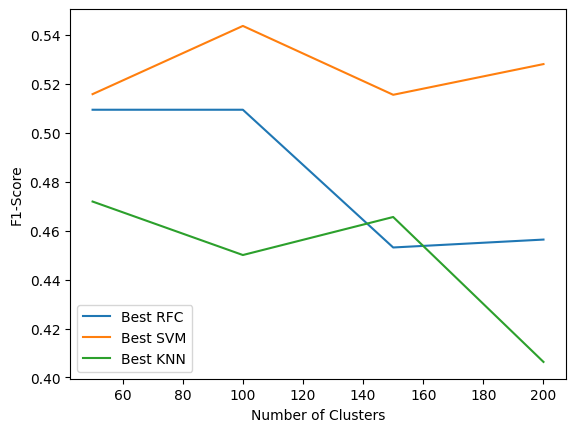

In [26]:
grid_search(detector, img_train, label_train, N_FOLDS, "ORB_grid_search.txt")

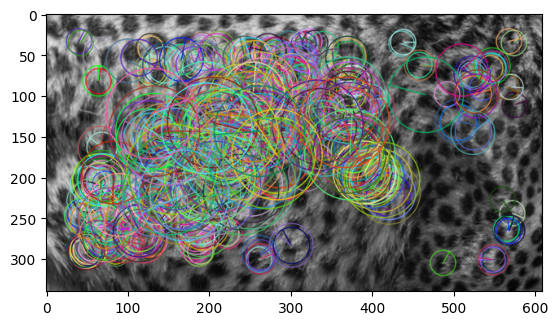

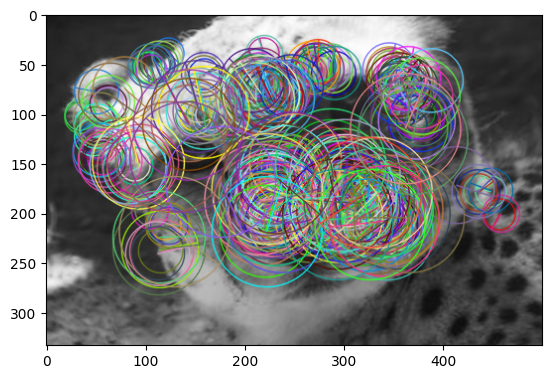

Evaluation with Random Forest Classifier:
Accuracy: 52.5%
F_1: 0.525


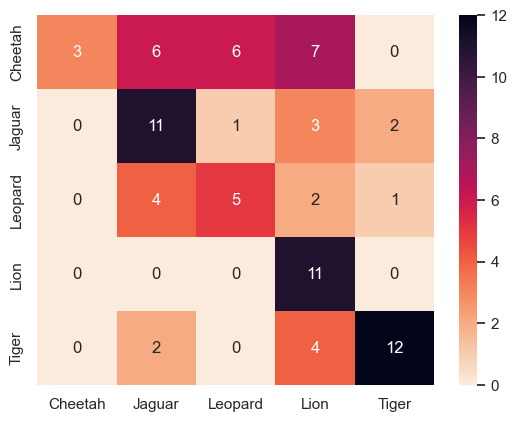

Class: Cheetah, AUC: 0.8671630094043888
Class: Jaguar, AUC: 0.7717086834733893
Class: Leopard, AUC: 0.7181372549019608
Class: Lion, AUC: 0.9591567852437417
Class: Tiger, AUC: 0.91084229390681


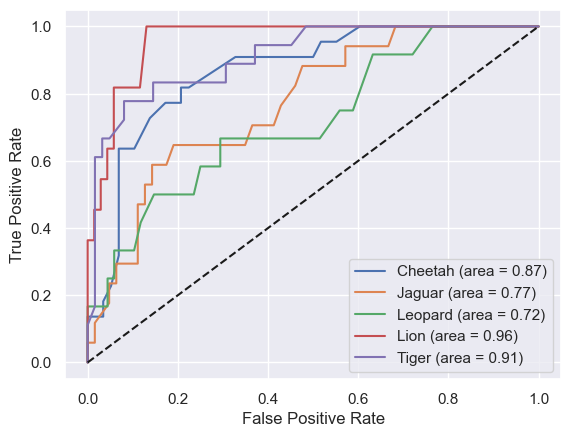


Evaluation with SVM:
Accuracy: 61.25000000000001%
F_1: 0.6125


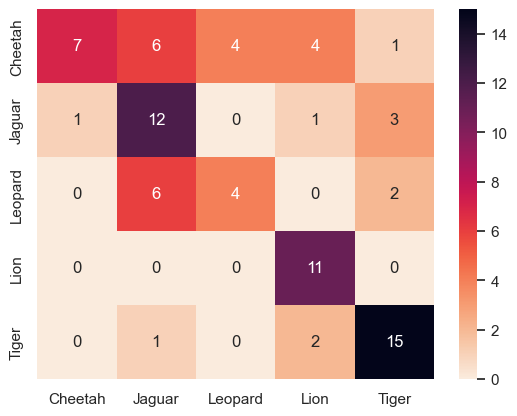

Class: Cheetah, AUC: 0.8377742946708464
Class: Jaguar, AUC: 0.7740429505135388
Class: Leopard, AUC: 0.7365196078431372
Class: Lion, AUC: 0.9881422924901186
Class: Tiger, AUC: 0.9543010752688171


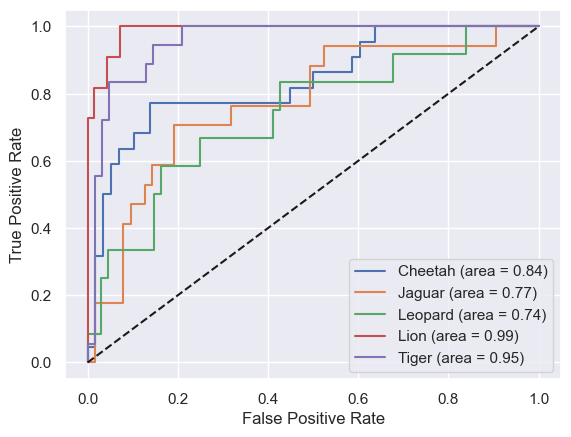


Evaluation with KNN Classifier:
Accuracy: 56.25%
F_1: 0.5625


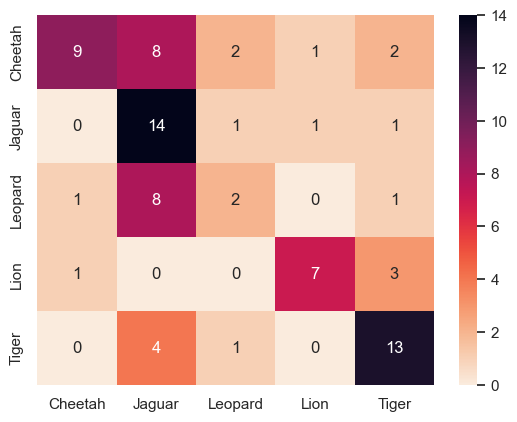

Class: Cheetah, AUC: 0.780564263322884
Class: Jaguar, AUC: 0.8104575163398692
Class: Leopard, AUC: 0.758578431372549
Class: Lion, AUC: 0.9565217391304347
Class: Tiger, AUC: 0.8942652329749103


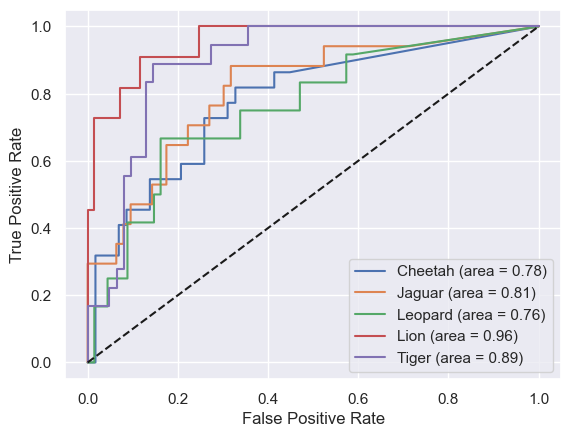

In [27]:
best_rfc = RandomForestClassifier(n_estimators=200, criterion='entropy', random_state=RANDOM_STATE)
best_svm = SVC(kernel='rbf')
best_knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
kmeans_train_features, label_train, kmeans_test_features, label_test = run_models(best_rfc, best_svm, best_knn, detector,\
    img_train, label_train, img_test, label_test, 100)

### Ensemble

Evaluation with soft voting (RFC, SVM, KNN):
Accuracy: 58.75%
F_1: 0.5875


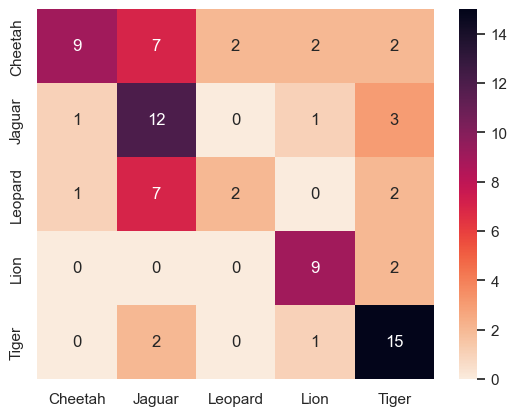

Class: Cheetah, AUC: 0.8440438871473354
Class: Jaguar, AUC: 0.8067226890756303
Class: Leopard, AUC: 0.8198529411764706
Class: Lion, AUC: 0.9855072463768115
Class: Tiger, AUC: 0.9462365591397849


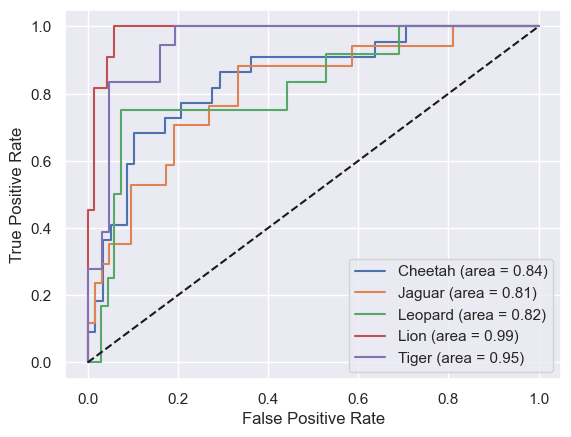


Evaluation with stacking (RFC, SVM, KNN):
Accuracy: 48.75%
F_1: 0.4875


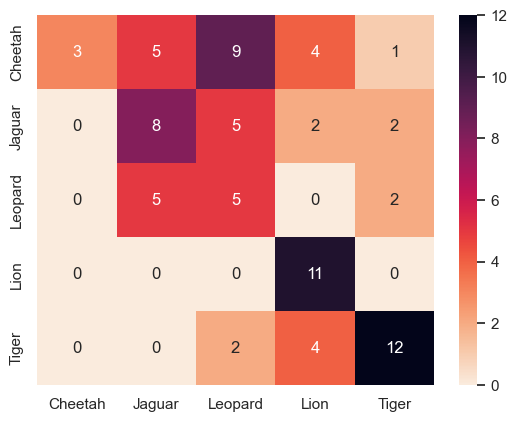

Class: Cheetah, AUC: 0.8322884012539185
Class: Jaguar, AUC: 0.7628384687208217
Class: Leopard, AUC: 0.7401960784313726
Class: Lion, AUC: 0.9644268774703557
Class: Tiger, AUC: 0.9444444444444444


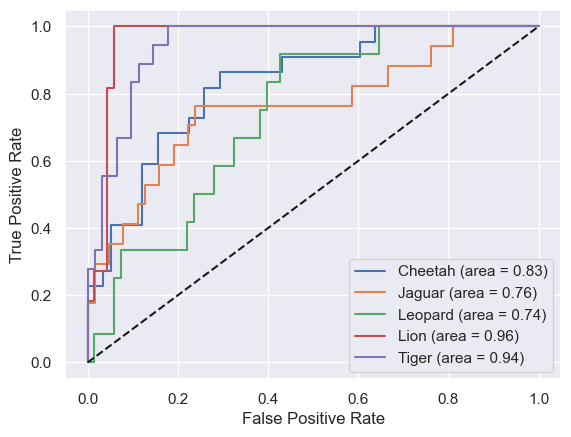

In [28]:
best_svm = SVC(kernel='rbf', probability=True)
run_ensembles(best_rfc, best_svm, best_knn, kmeans_train_features, label_train, kmeans_test_features, label_test)

### Clustering

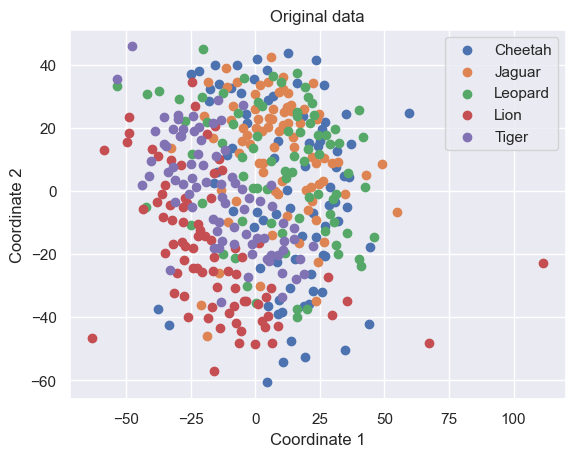

Silhouette: 0.04767523915977799 
Mutual information: 0.17591087525682972


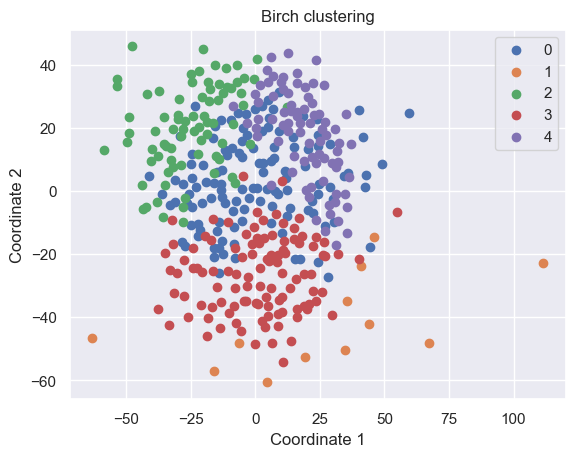

In [29]:
clustering_and_vis(Birch(threshold=0.03, n_clusters=5), np.vstack((kmeans_train_features, kmeans_test_features)), label_train + label_test)

## SIFT pipeline

### Classification

In [30]:
detector = cv.SIFT_create()

#### Grid search

Mean F1-score (± 1 SD) for 50 clusters after 3-fold cross validation:
	- RFC, n_estimators=200.0, criterion=entropy: 0.6561159113618996 ± 0.06342710730639642
	- SVM, kernel=linear: 0.7060777052841943 ± 0.08481118365519882
	- KNN, n_neighbors=3.0, weights=distance: 0.6531769823076471 ± 0.03152175069891647

Mean F1-score (± 1 SD) for 100 clusters after 3-fold cross validation:
	- RFC, n_estimators=100.0, criterion=entropy: 0.6623758302474577 ± 0.0508095872165822
	- SVM, kernel=linear: 0.7344089813671898 ± 0.02092985929204548
	- KNN, n_neighbors=3.0, weights=uniform: 0.6407453124081585 ± 0.05366935091392832

Mean F1-score (± 1 SD) for 150 clusters after 3-fold cross validation:
	- RFC, n_estimators=50.0, criterion=entropy: 0.6624933874096278 ± 0.0561047021699009
	- SVM, kernel=linear: 0.7342914242050197 ± 0.023161203710216894
	- KNN, n_neighbors=3.0, weights=distance: 0.6532945394698172 ± 0.08054415368459471

Mean F1-score (± 1 SD) for 200 clusters after 3-fold cross validation:
	- RFC, n

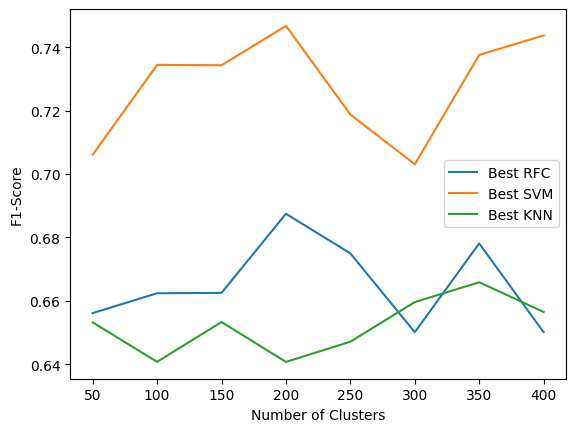

In [31]:
grid_search(detector, img_train, label_train, N_FOLDS, "SIFT_grid_search.txt")

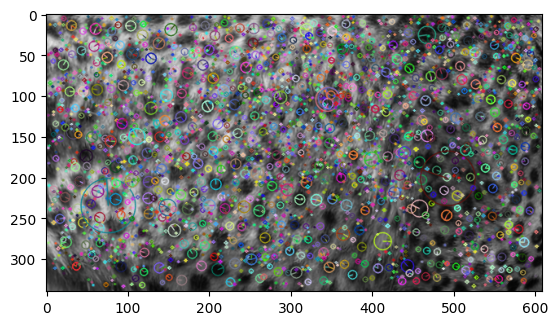

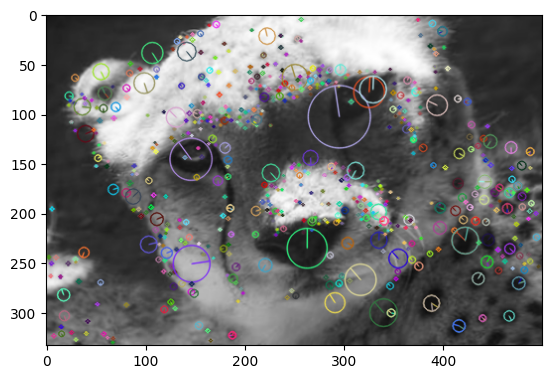

Evaluation with Random Forest Classifier:
Accuracy: 63.74999999999999%
F_1: 0.6375


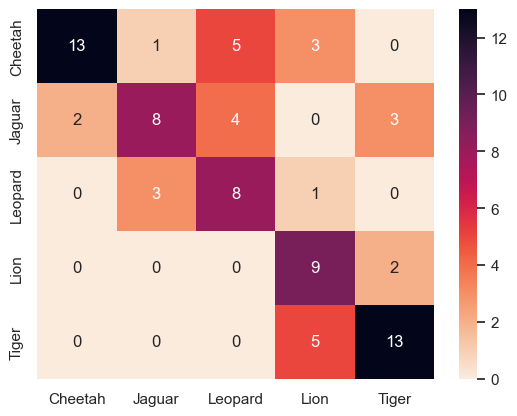

Class: Cheetah, AUC: 0.9302507836990597
Class: Jaguar, AUC: 0.8323996265172735
Class: Leopard, AUC: 0.8560049019607844
Class: Lion, AUC: 0.9479578392621871
Class: Tiger, AUC: 0.9601254480286738


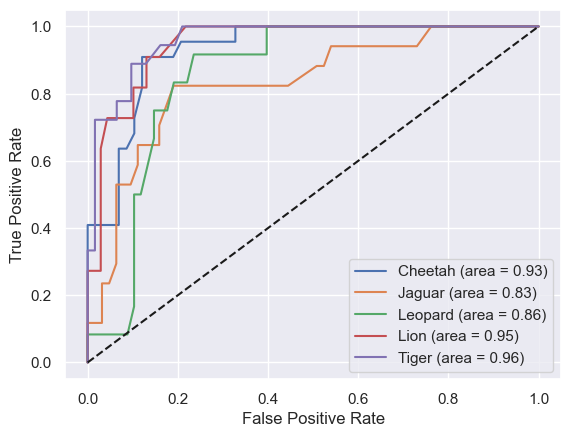


Evaluation with SVM:
Accuracy: 68.75%
F_1: 0.6875


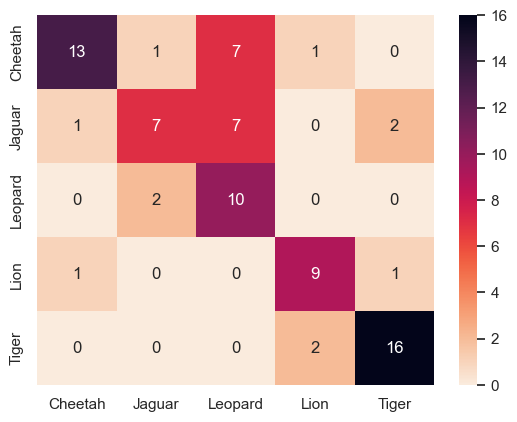

Class: Cheetah, AUC: 0.9036050156739812
Class: Jaguar, AUC: 0.8123249299719888
Class: Leopard, AUC: 0.8713235294117647
Class: Lion, AUC: 0.9762845849802372
Class: Tiger, AUC: 0.9650537634408602


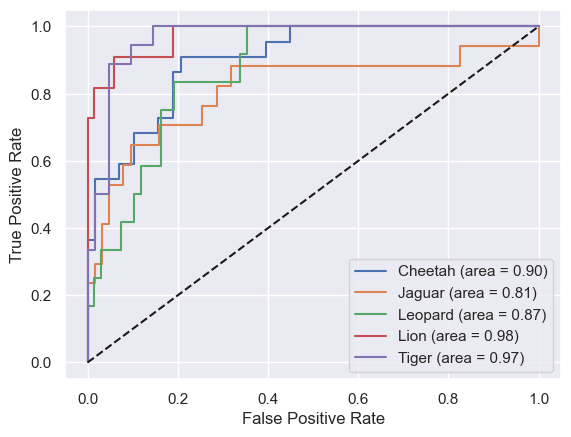


Evaluation with KNN Classifier:
Accuracy: 68.75%
F_1: 0.6875


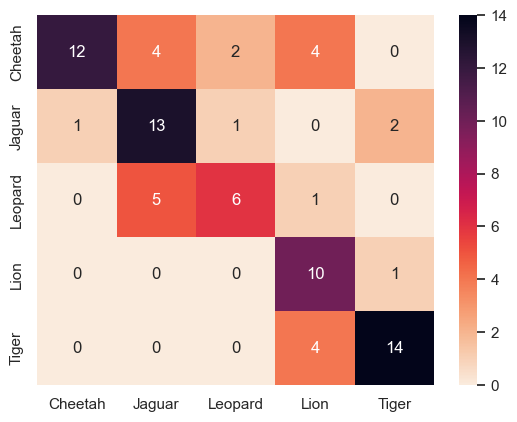

Class: Cheetah, AUC: 0.8534482758620688
Class: Jaguar, AUC: 0.8552754435107377
Class: Leopard, AUC: 0.8872549019607844
Class: Lion, AUC: 0.9657444005270093
Class: Tiger, AUC: 0.9820788530465949


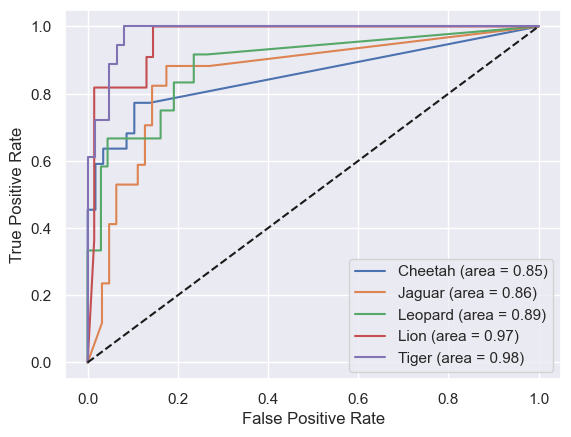

In [32]:
best_rfc = RandomForestClassifier(n_estimators=150, criterion='entropy', random_state=RANDOM_STATE)
best_svm = SVC(kernel='linear')
best_knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
kmeans_train_features, label_train, kmeans_test_features, label_test = run_models(best_rfc, best_svm, best_knn, detector,\
    img_train, label_train, img_test, label_test, 200)

### Ensemble

Evaluation with soft voting (RFC, SVM, KNN):
Accuracy: 66.25%
F_1: 0.6625


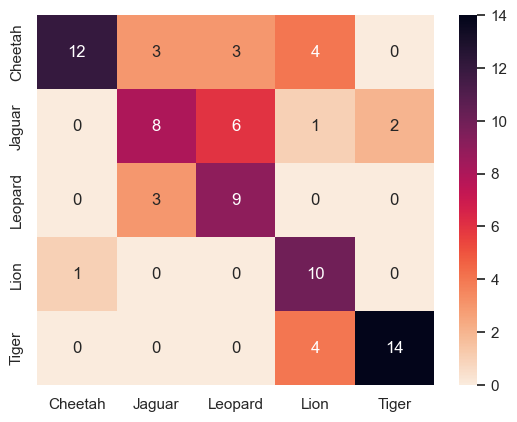

Class: Cheetah, AUC: 0.9561128526645768
Class: Jaguar, AUC: 0.865546218487395
Class: Leopard, AUC: 0.9154411764705882
Class: Lion, AUC: 0.9762845849802371
Class: Tiger, AUC: 0.9820788530465949


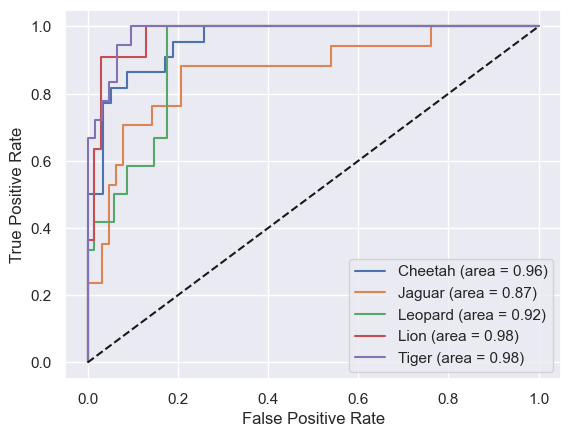


Evaluation with stacking (RFC, SVM, KNN):
Accuracy: 71.25%
F_1: 0.7125


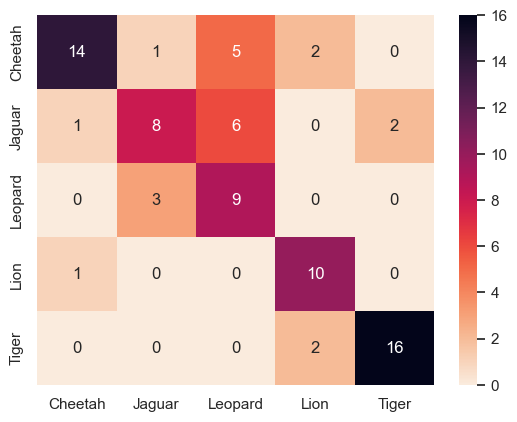

Class: Cheetah, AUC: 0.9592476489028212
Class: Jaguar, AUC: 0.8851540616246498
Class: Leopard, AUC: 0.9325980392156863
Class: Lion, AUC: 0.9762845849802372
Class: Tiger, AUC: 0.9838709677419355


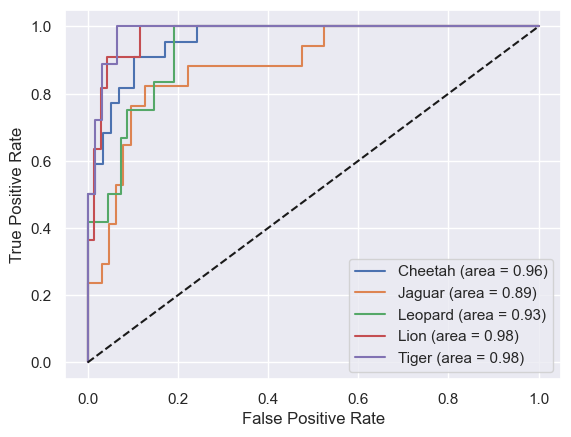

In [33]:
best_svm = SVC(kernel='linear', probability=True)
run_ensembles(best_rfc, best_svm, best_knn, kmeans_train_features, label_train, kmeans_test_features, label_test)

### Clustering

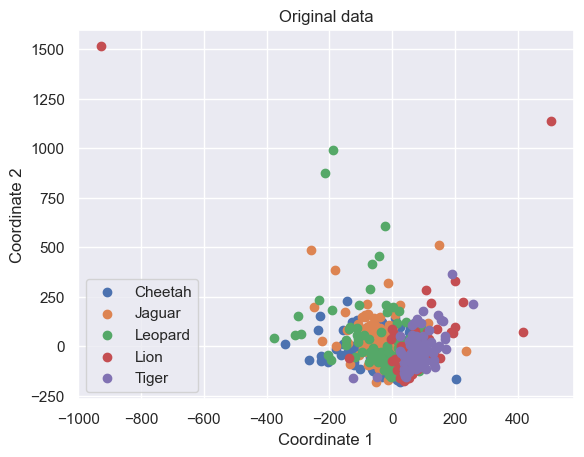

Silhouette: 0.2435826894919816

Mutual information: 0.09003730027500763


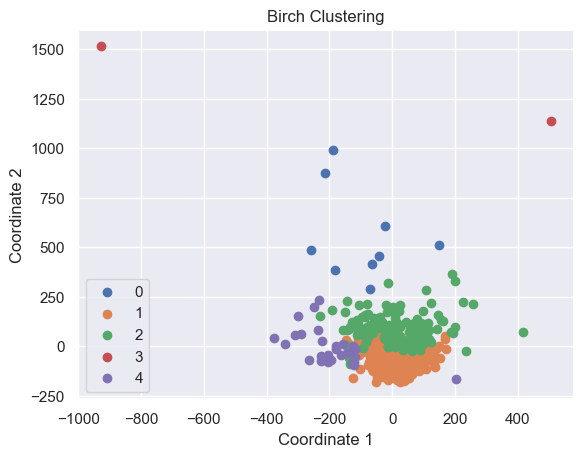

In [34]:
clustering_and_vis(Birch(threshold=0.03, n_clusters=5), np.vstack((kmeans_train_features, kmeans_test_features)), label_train + label_test)

## Original data pipeline

### Classification

#### Grid search

In [35]:
def best_gs_model(model, params, n_folds, scoring):
    gs = GridSearchCV(model, params, cv=n_folds, scoring=scoring)
    gs.fit(img_train_flat, label_train)
    return gs.best_params_

param_rfc = {'n_estimators':[50, 100, 150, 200], 'criterion':['gini', 'entropy', 'log_loss'], 'random_state':[RANDOM_STATE], 'n_jobs':[-1]}
best_rfc = RandomForestClassifier(**best_gs_model(RandomForestClassifier(), param_rfc, N_FOLDS, 'f1_micro'))

param_svm = {'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
best_svm = SVC(**best_gs_model(SVC(), param_svm, N_FOLDS, 'f1_micro'))

param_knn = {'n_neighbors':[3, 5, 7], 'weights':['uniform', 'distance'], 'n_jobs': [-1]}
best_knn = KNeighborsClassifier(**best_gs_model(KNeighborsClassifier(), param_knn, N_FOLDS, 'f1_micro'))

#### Evaluation

Evaluation with Random Forest Classifier:
Accuracy: 33.75%
F_1: 0.3375


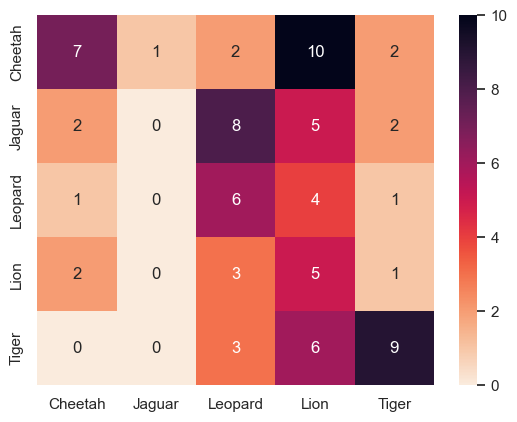

Class: Cheetah, AUC: 0.8087774294670846
Class: Jaguar, AUC: 0.7245564892623717
Class: Leopard, AUC: 0.7493872549019608
Class: Lion, AUC: 0.6752305665349144
Class: Tiger, AUC: 0.7625448028673834


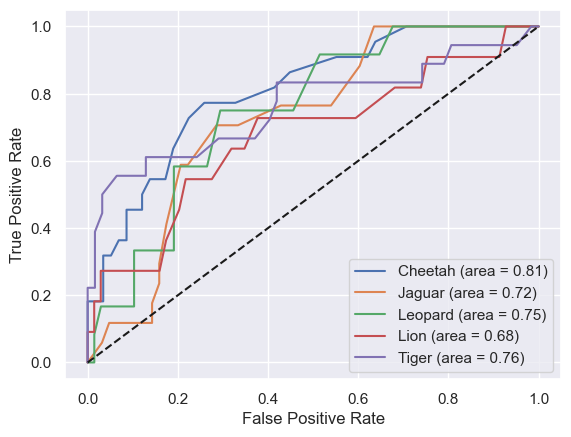


Evaluation with SVM:
Accuracy: 35.0%
F_1: 0.35


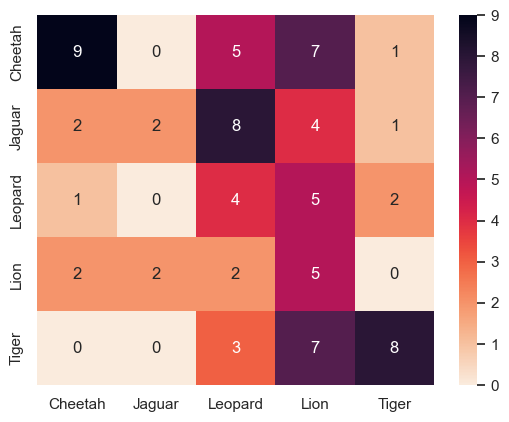

Class: Cheetah, AUC: 0.7460815047021943
Class: Jaguar, AUC: 0.8095238095238095
Class: Leopard, AUC: 0.6727941176470589
Class: Lion, AUC: 0.6640316205533596
Class: Tiger, AUC: 0.7401433691756272


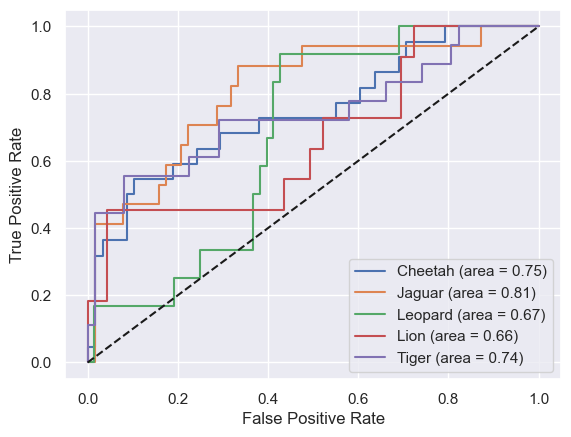


Evaluation with KNN Classifier:
Accuracy: 18.75%
F_1: 0.1875


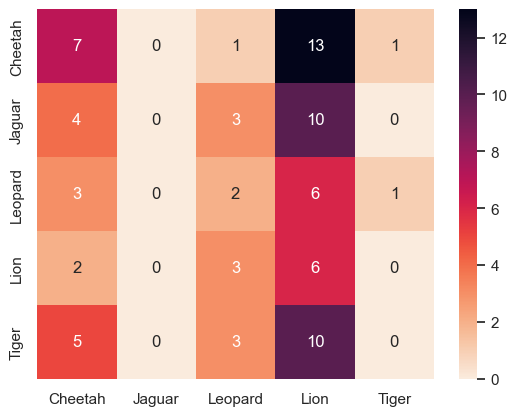

Class: Cheetah, AUC: 0.6728056426332287
Class: Jaguar, AUC: 0.5882352941176471
Class: Leopard, AUC: 0.4969362745098039
Class: Lion, AUC: 0.45520421607378125
Class: Tiger, AUC: 0.5672043010752689


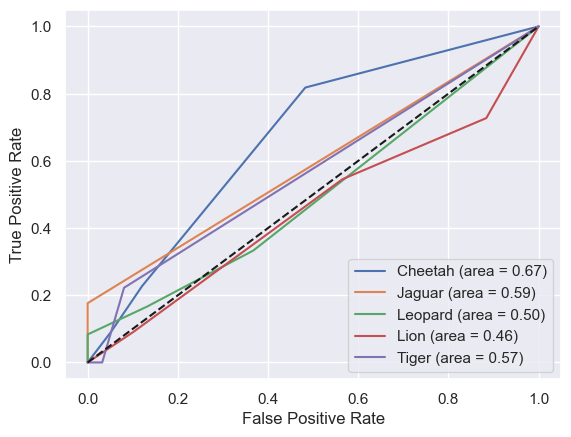

In [36]:
print("Evaluation with Random Forest Classifier:")
evaluate_model(best_rfc, img_train_flat, label_train, img_test_flat, label_test)

print("\nEvaluation with SVM:")
evaluate_model(best_svm, img_train_flat, label_train, img_test_flat, label_test)

print("\nEvaluation with KNN Classifier:")
evaluate_model(best_knn, img_train_flat, label_train, img_test_flat, label_test)

#### Ensemble

Evaluation with soft voting (RFC, SVM, KNN):
Accuracy: 22.5%
F_1: 0.225


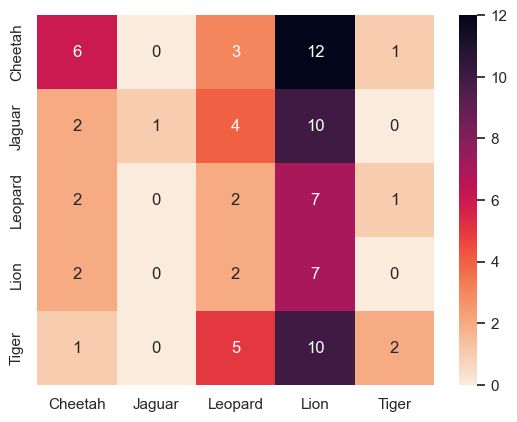

Class: Cheetah, AUC: 0.7727272727272727
Class: Jaguar, AUC: 0.7777777777777778
Class: Leopard, AUC: 0.6495098039215687
Class: Lion, AUC: 0.5586297760210803
Class: Tiger, AUC: 0.7222222222222223


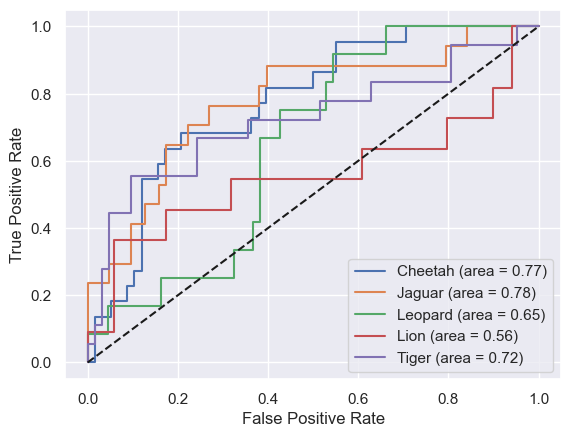


Evaluation with stacking (RFC, SVM, KNN):
Accuracy: 33.75%
F_1: 0.3375


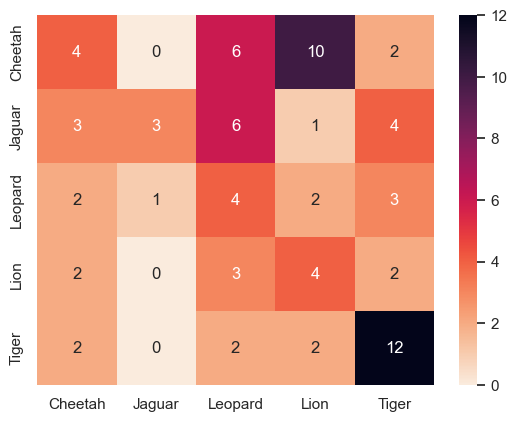

Class: Cheetah, AUC: 0.6426332288401255
Class: Jaguar, AUC: 0.6872082166199813
Class: Leopard, AUC: 0.5943627450980392
Class: Lion, AUC: 0.6231884057971014
Class: Tiger, AUC: 0.782258064516129


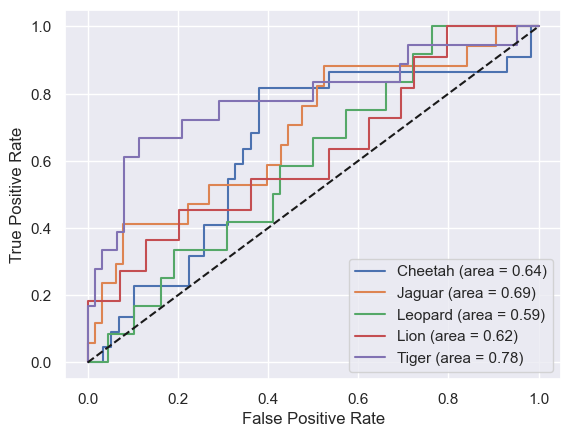

In [37]:
best_svm = SVC(**best_gs_model(SVC(), param_svm, N_FOLDS, 'f1_micro'), probability=True)
run_ensembles(best_rfc, best_svm, best_knn, img_train_flat, label_train, img_test_flat, label_test)

### Clustering

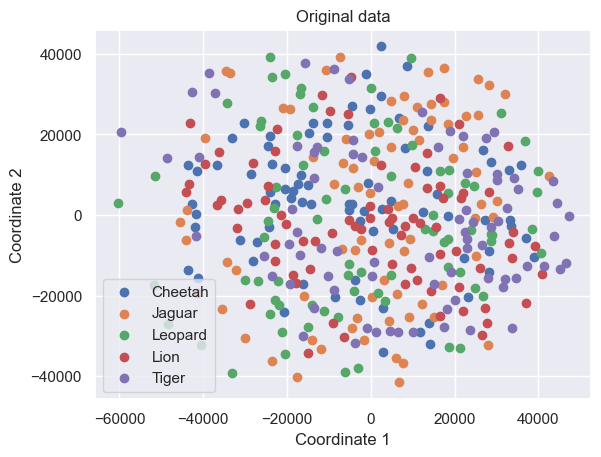

c:\Users\alina\anaconda3\envs\cogrob\lib\site-packages\sklearn\cluster\_birch.py:320: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
c:\Users\alina\anaconda3\envs\cogrob\lib\site-packages\sklearn\cluster\_birch.py:752: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(


Silhouette score cannot be calculated, as only one cluster was found.
Mutual information: 0.0


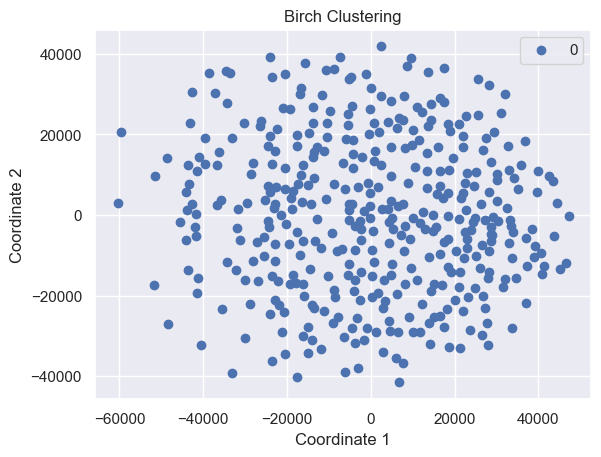

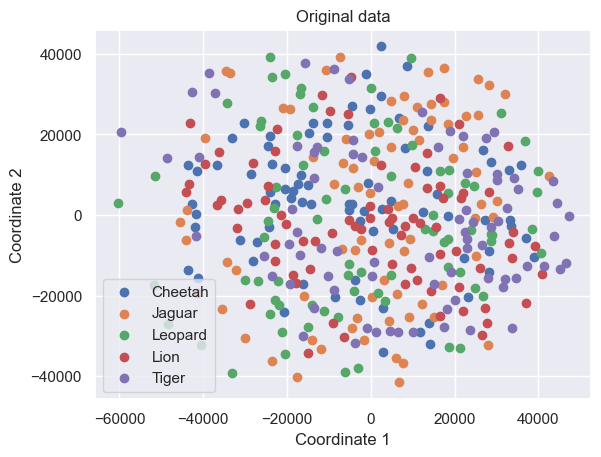

Silhouette score cannot be calculated, as only one cluster was found.
Mutual information: 0.0


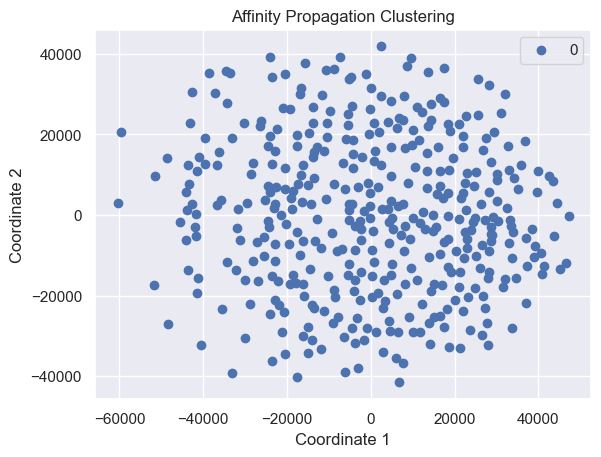

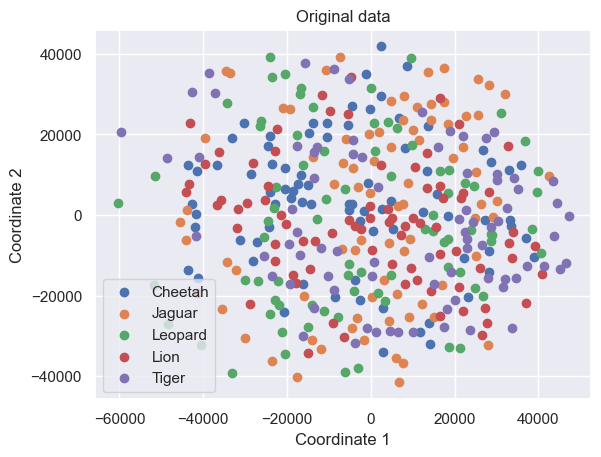

Silhouette: 0.016956982206945838

Mutual information: 0.14008342046419492


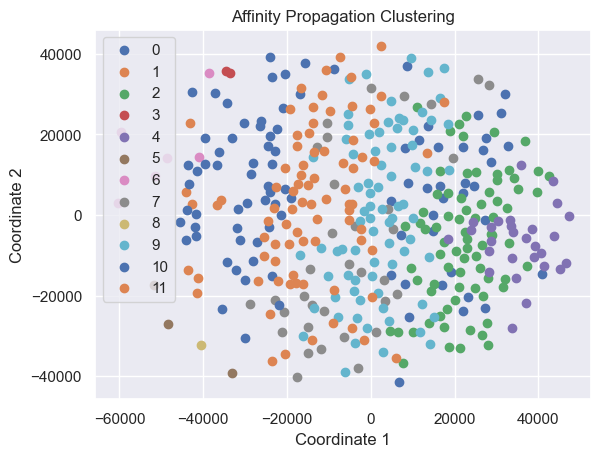

In [38]:
clustering_and_vis(Birch(threshold=0.00001, n_clusters=5), np.vstack((img_train_flat, img_test_flat)), label_train + label_test)
clustering_and_vis(AffinityPropagation(damping=0.99), np.vstack((img_train_flat, img_test_flat)), label_train + label_test, "Affinity Propagation")
clustering_and_vis(AffinityPropagation(damping=0.5), np.vstack((img_train_flat, img_test_flat)), label_train + label_test, "Affinity Propagation")